In [1]:
import setGPU

import sys, os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

sys.path.append('..')

from utils import datasetUtils
from extractEmbeddings import featureExtractor, fvsOperations

setGPU: Setting GPU to: 1


/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
testCases = []
testCases.append('../../../data/movie_titles/testUncompressed/710892EE-71C2-424A-8C8E-B932650D0C8D')
testCases.append('../../../data/movie_titles/testUncompressed/BA4C126E-C1FB-4D3B-B005-EAC8FB1D8AE6')
testCases.append('../../../data/movie_titles/testUncompressed/A87CF0B8-B7CB-4966-974E-08EA74DCEC7E')
testCases.append('../../../data/movie_titles/testUncompressed/355B709B-C088-41F3-BAD2-5C5815753B69')
testCases.append('../../../data/movie_titles/testUncompressed/DD9D94DE-F340-4BC0-8A81-7688C43E3384')
testCases.append('../../../data/movie_titles/testUncompressed/007A7335-5CD9-4549-B8BD-6F9D090C7367')
testCases.append('../../../data/movie_titles/testUncompressed/FEEEDE0D-FD34-4517-A690-C2F04E3739BE')
testCases.append('../../../data/movie_titles/testUncompressed/661AD029-A96F-427F-99B7-2C44E01027EF')

In [4]:
featExt = featureExtractor(1000, 'ENB5')
model = featExt.pretrainedModel()
dUtils = datasetUtils()
fvsOps = fvsOperations()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
def computeSimMatrix(arrTestFvs, titleFvs):
    
    #Compute title fvs norm
    titleFvsRowNorm = np.linalg.norm(titleFvs, axis=1)
    titleNormMat = np.divide(titleFvs, titleFvsRowNorm[:, None])
    #print(titleNormMat.shape)
    
    #compute test fvs norm
    testFvsRowNorm = np.linalg.norm(arrTestFvs, axis=1)
    testNormMat = np.divide(arrTestFvs, testFvsRowNorm[:, None])
    #print(testNormMat.shape)
    
    #multiply title and test fvs
    simMat = np.matmul(titleNormMat, testNormMat.T)
    #print(simMat.shape)

    #Find out the indices of max score in result matrix
    max_ind = np.where(np.max(simMat, axis=0) == simMat)
    rowInds = max_ind[0]
    colInds = max_ind[1]
    
    #Accumulate max score in each matrix
    accScore = 0
    for ind in range(len(rowInds)):
        rI = rowInds[ind]
        cI = colInds[ind]
        accScore += simMat[rI][cI]
        
    return (accScore/len(rowInds)), rowInds

In [31]:
def displayFrames(fnames, indices):
    for ind in indices:
        fname = fnames[ind]
        fname = '../'+fname
        fname = fname.rstrip()
        if not os.path.exists(fname):
            print("file name does not exists",fname)
        img = cv.imread(fname)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    plt.show()

In [32]:
def displayTestFrames(fnames):
    for fname in fnames:
        if not os.path.exists(fname):
            print("file name does not exists",fname)
        img = cv.imread(fname)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    plt.show()

In [35]:
def displayMatchedFrames(testFileNames, titleMatchedFileNames):
    nRows = len(testFileNames)
    nCols = 2
    plt.figure(figsize=(50,40))
    for tcFileName, titleFileName in zip(testFileNames, titleMatchedFileNames):
        titleFileName = '../'+titleFileName
        
        tcImg = cv.imread(tcFileName)
        plt.subplot(nRows, nCols, 1)
        plt.axis('off')
        plt.imshow(tcImg)

        titleImg = cv.imread(titleFileName.rstrip())
        plt.subplot(nRows, nCols, 2)
        plt.axis('off')
        plt.imshow(titleImg)
    plt.show()

3D6C53DB-054A-4935-9872-AB2C6093C29F
Actual title:5454, Predicted title:5454


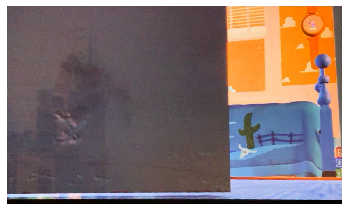

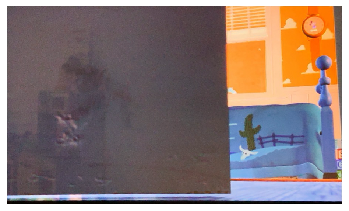

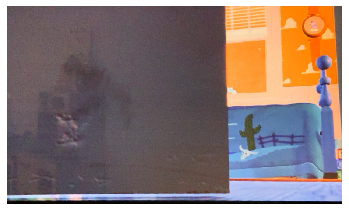

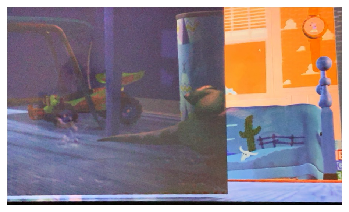

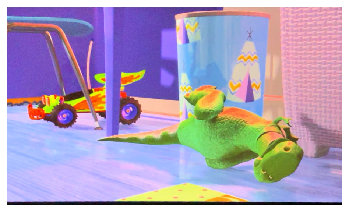

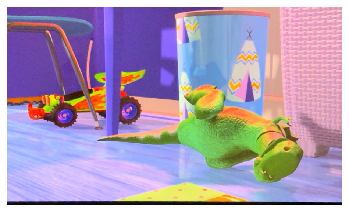

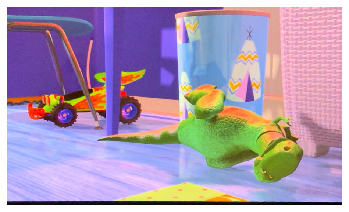

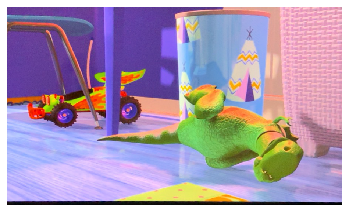

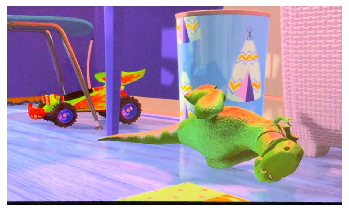

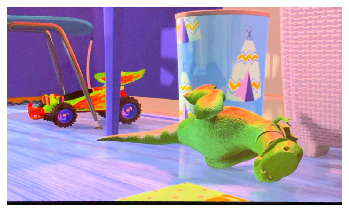

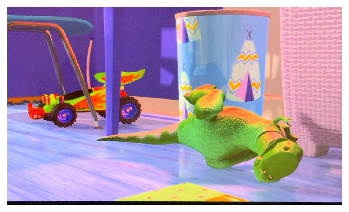

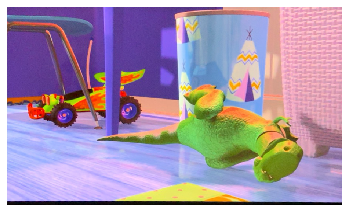

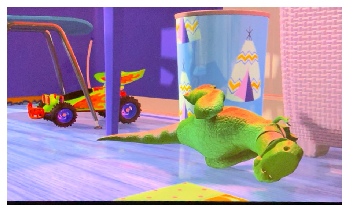

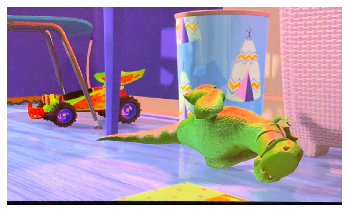

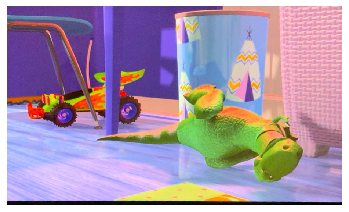

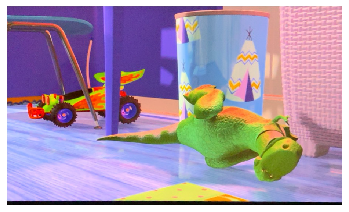

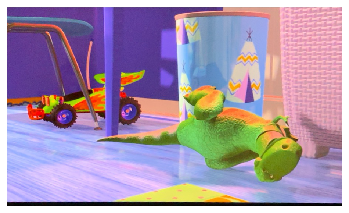

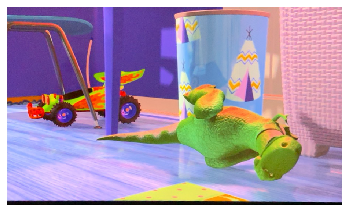

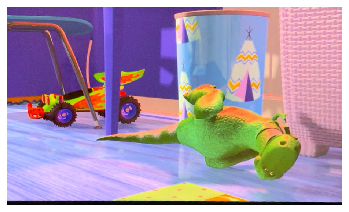

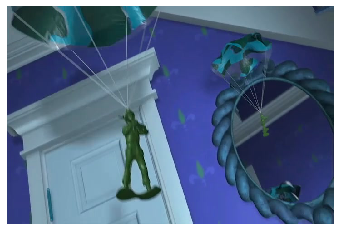

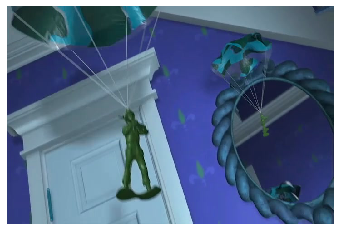

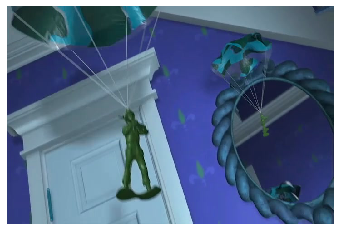

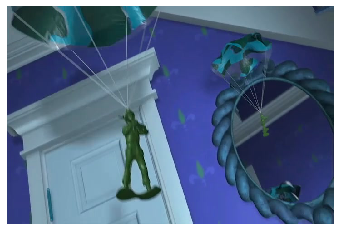

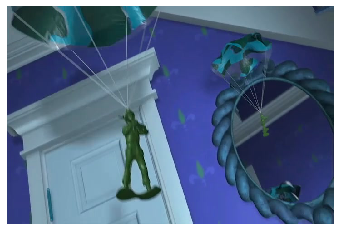

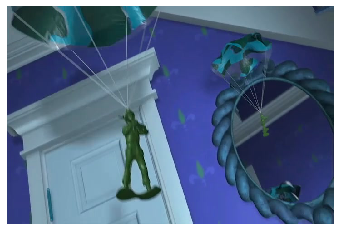

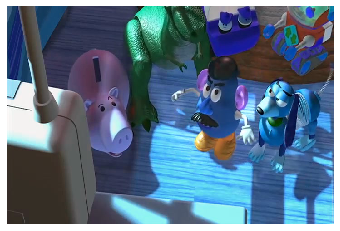

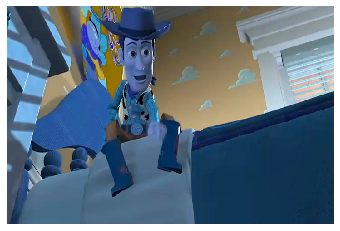

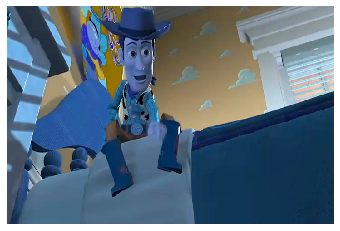

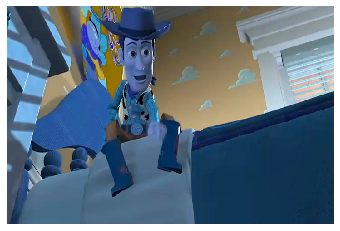

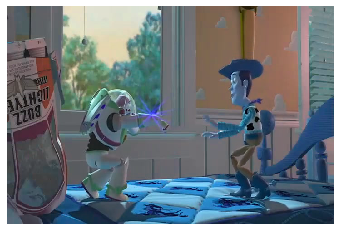

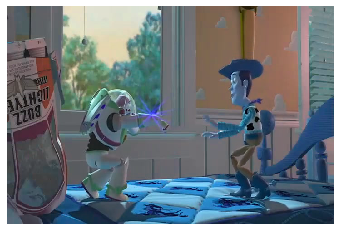

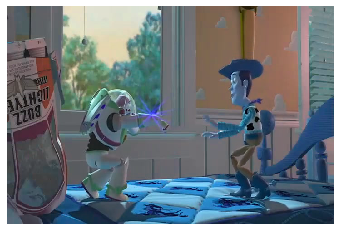

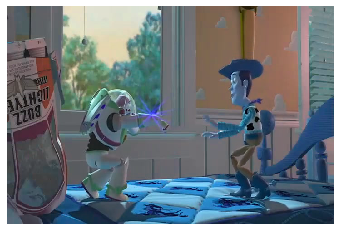

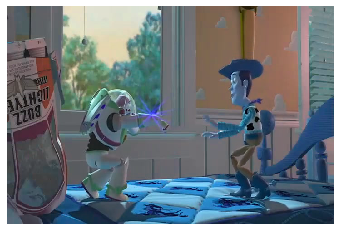

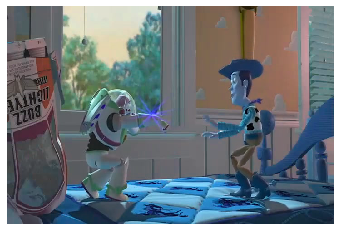

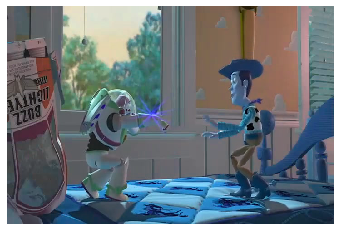

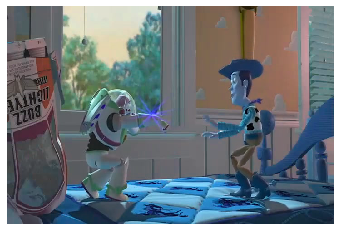

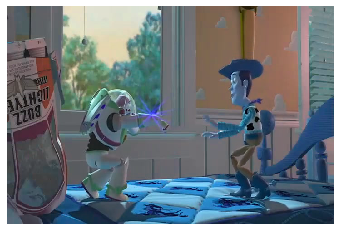

In [34]:
count = 0
titlesPath = '../../../data/movie_titles/all_titles_uncompressed/'
testCasesPath = '../../../data/movie_titles/testUncompressed/'

for testCaseName in os.listdir(testCasesPath): #iterate for each test case
    print(testCaseName)
    testCasePath = os.path.join(testCasesPath, testCaseName)
    actualTitle, actualTime = dUtils.parseTestCaseJsonFile(testCasePath)
    testFvs, tfNames = featExt.extractFeaturesTitle(testCasePath, model)
    arrTestFvs = np.asarray(testFvs).squeeze()
    
    minScore = 9999
    matchedTitle = ''
    matchedFrameIndices = 0
    titleFileNames = ''
    for titleName in os.listdir(titlesPath): #iterate for each title

        #print(titleName)
        titlePath = os.path.join(titlesPath, titleName)
        matFileName = titleName+'ENB5.mat'
        matFilePath = os.path.join(titlePath, matFileName)
        if not os.path.exists(matFilePath):
            print("mat file does not exists",matFilePath)
            continue
        fvs, fnames = dUtils.loadMatFile(matFilePath)
        titleFvs = np.asarray(fvs).squeeze()
        
        #simScore, rowInds = computeSimMatrix(arrTestFvs, titleFvs)
        simScore, rowInds = fvsOps.computeSimMatrix(titleFvs, arrTestFvs)
        if minScore > simScore:
            minScore = simScore
            matchedTitle = titleName
            matchedFrameIndices = rowInds
            titleFileNames = fnames
            
    print("Actual title:{}, Predicted title:{}".format(actualTitle, matchedTitle))
    
    titleMatchedFileNames = []
    for ind in rowInds:
        titleMatchedFileNames.append(titleFileNames[ind])
    
    displayMatchedFrames(tfNames, titleMatchedFileNames)
    #displayTestFrames(tfNames)
    #displayFrames(titleFileNames, rowInds)
    count += 1
    if count > 0:
        break